# Data Wrangling & EDA
Last Updated: Mar 2, 2024

## Exercise Goal
Uncover actionable insights on how to improve user adoption rates by identifying key factors that influence users to engage with the product more frequently and consistently.


## Requirements:
The data is available as two attached CSV files:
- `takehome_user_engagement.csv`
- `takehome_users.csv`

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

Send a brief writeup of your findings (the more concise, the better, no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

## Table of Contents
1. [Load & Parse Data](#load--parse-data)
2. [Data Check & Cleaning](#data-check--cleaning)
3. [Create Possible Features](#create-possible-features)
4. [Exploratory Analysis](#exploratory-analysis)
5. [Correlation Analysis](#correlation-analysis)
6. [Conclusion](#conclusion)

## Load Libraries

In [2]:
import datetime
import sys

# Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
sns.set_style("darkgrid")

print(sys.version)
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Seaborn version: {sns.__version__}')


3.11.8 (main, Feb 26 2024, 15:36:12) [Clang 14.0.6 ]
Pandas version: 2.1.4
Numpy version: 1.26.4
Seaborn version: 0.13.2


## Load & Parse Data

### 1. takehome_users.csv

A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login
id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
- enabled_for_marketing_drip: whether they are on the regular
marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

In [3]:
# Load "User Engagement" data
df_user = pd.read_csv(
    filepath_or_buffer='takehome_users.csv', 
    encoding='latin-1' 
)
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### 2. takehome_user_engagement.csv 

A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

In [4]:
# Load "User Engagement" data
df_user_engagement = pd.read_csv('takehome_user_engagement.csv')
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### 3. Parse Data

In [5]:
# Convert 'time_stamp' to datetime in engagement dataframe
df_user_engagement['time_stamp'] = pd.to_datetime(df_user_engagement['time_stamp'])

# Convert 'creation_time' to datetime and 'last_session_creation_time' from UNIX time to datetime in users dataframe
df_user['creation_time'] = pd.to_datetime(df_user['creation_time'], format='%m/%d/%y %H:%M')
df_user['last_session_creation_time'] = pd.to_datetime(df_user['last_session_creation_time'], unit='s', errors='coerce') #  forces any errors during conversion (e.g., incompatible or corrupt data) to result in NaT values.


# Verify successful changes
print(f'''df_user_engagement:
{df_user_engagement.dtypes}
''')

print(f'''df_user:
{df_user.dtypes}
''')

df_user_engagement:
time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

df_user:
object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object


## Data Check & Cleaning

### 1. Defining "Current" Time

Since the case study was created a while ago, we'll need to make an assumption of which date is considered "current", mainly used to calculate days/months elapsed from a certain datetime.

We'll assume the last timestamp on "df_user_engagement" as the most recent "current" time.

In [6]:
CURRENT_TIME = pd.to_datetime(df_user_engagement['time_stamp'].max())
CURRENT_TIME

Timestamp('2014-06-06 14:58:50')

### 1. Check missing values

#### "df_user_engagement" table

Looks fine (no missing values).

In [7]:
pd.concat(
    [
        df_user_engagement.isnull().sum().sort_values(ascending=False),
        df_user_engagement.count()
    ],
    axis=1,
    keys=['blank_count', 'non_blank_count']
)

,blank_count,non_blank_count
time_stamp,0,207917
user_id,0,207917
visited,0,207917


"df_user" table

There are blanks found:
- "last_session_creation_time": Looking for random sample, blank appeared to be users who have never interacted with the platform.
- "invited_by_user_id":  Looking from random sample, blank appeared to be users who were not referred.

In [8]:
pd.concat(
    [
        df_user.isnull().sum().sort_values(ascending=False),
        df_user.count()
    ],
    axis=1,
    keys=['blank_count', 'non_blank_count']
)

,blank_count,non_blank_count
invited_by_user_id,5583,6417
last_session_creation_time,3177,8823
object_id,0,12000
creation_time,0,12000
name,0,12000
email,0,12000
creation_source,0,12000
opted_in_to_mailing_list,0,12000
enabled_for_marketing_drip,0,12000
org_id,0,12000


Check for sample data where "last_session_creation_time" is null

In [9]:
# Check for sample data where "last_session_creation_time" is null
df_user[df_user['last_session_creation_time'].isnull()].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:00,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:00,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
11,12,2014-04-17 23:48:00,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0
14,15,2013-07-16 21:33:00,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN
15,16,2013-02-11 10:09:00,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN


Confirming that there's no user engagement for users with blank "last_session_creation_time"

In [10]:
# Confirming that there's no user engagement for users with blank "last_session_creation_time"
df_user_engagement[df_user_engagement['user_id'].isin([8, 9, 12, 15, 16])]

,time_stamp,user_id,visited


Check for sample data where "invited_by_user_id" is null

In [11]:
# Check for sample data where "invited_by_user_id" is null
df_user[df_user['invited_by_user_id'].isnull()].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6,7,2012-12-16 13:24:00,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN
7,8,2013-07-31 05:34:00,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:00,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
10,11,2013-12-26 03:55:00,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,2013-12-27 03:55:54,0,0,69,NaN
13,14,2012-10-11 16:14:00,Rivera Bret,BretKRivera@gmail.com,SIGNUP,2012-10-12 16:14:33,0,0,0,NaN


### 2. Check duplicates

No duplicates found on both "df_user_engagement" and "df_user" tables.

In [12]:
print(f'df_user_engagement duplicate count: {df_user_engagement.duplicated().sum()}')

df_user_engagement duplicate count: 0


In [13]:
# It should be unique by each "object_id" (which is the user's id)
print(f"df_user duplicate count: {df_user['object_id'].duplicated().sum()}")

df_user duplicate count: 0


## Create Possible Features

### 1. Create "is_adopted_user" (target variable)

Definition: a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [14]:
# Create a column to label each user if they have visited a site at least 3 times within any given 7-day period

# Set 'time_stamp' as index for "resample" method
df_user_engagement.set_index('time_stamp', inplace=True)

# Get total weekly visit count by each user
df_user_weekly_visit_count = df_user_engagement.groupby('user_id').resample('W').agg({'visited': 'sum'}).rename(columns={'visited': 'weekly_visit_count'})

# Filter for users who at least have visited >=3 times in any given week (7-day period)
df_user_weekly_visit_count.reset_index(inplace=True)

adopted_users = df_user_weekly_visit_count[df_user_weekly_visit_count['weekly_visit_count'] >= 3]['user_id'].unique()

In [15]:
# CHECK THE 16%

total_user_count = df_user_engagement['user_id'].nunique()
adopted_user_count = len(adopted_users)
adoption_percentage = np.round(adopted_user_count/total_user_count, 4)
print(f'''Out of {total_user_count} users, {adopted_user_count} ({adoption_percentage*100}%) have visited the platform at least 3 times in any given week once.''')

Out of 8823 users, 1445 (16.38%) have visited the platform at least 3 times in any given week once.


In [16]:
# Finally, add this flag as a new column
df_user['is_adopted_user'] = df_user['object_id'].isin(adopted_users)
pd.concat(
    [
        df_user['is_adopted_user'].value_counts(),
        df_user['is_adopted_user'].value_counts(normalize=True)
    ],
    axis=1
)

,count,proportion
is_adopted_user,,
False,10555,0.879583
True,1445,0.120417


### 2. User account age in month
Definition: how many months since the user created an account

In [17]:
warnings.filterwarnings('ignore')

# 2. User account age in months
df_user['account_age_month'] = (
    # (today - user's account create date) / 30 days
    (CURRENT_TIME - df_user['creation_time']) / np.timedelta64(30, 'D')
).astype(int)

### 3. User average weekly visits count
Definition: Average weekly visit count per user 

In [18]:
df_weekly_average_user_visit = df_user_weekly_visit_count.groupby('user_id').agg({'weekly_visit_count': 'mean'}).rename(columns={'weekly_visit_count': 'weekly_average_visit_count'})
df_user = df_user.merge(
    df_weekly_average_user_visit,
    how='left',
    left_on='object_id',
    right_on='user_id'
)

### 4. Days elapsed since last user visit
Definition: How many days have elapsed since user last visited

In [19]:
# Days elapsed since last user visit
df_user['days_since_last_visit'] = ((CURRENT_TIME - df_user['last_session_creation_time']) / np.timedelta64(30, 'D'))

### 5. Has user visited at least once
Definition: Marking if a user has at least visited once 

In [20]:
df_user['has_visited_at_least_once'] = df_user['last_session_creation_time'].notnull()
df_user['has_visited_at_least_once'].value_counts(normalize=True)

has_visited_at_least_once
True     0.73525
False    0.26475
Name: proportion, dtype: float64

### 6. "joined_through_referral" field
Definition: Marking if a user joined through an invitation from another user. 

In [21]:
df_user['joined_through_referral'] = df_user['invited_by_user_id'].notnull()
df_user.groupby('is_adopted_user')['joined_through_referral'].value_counts(normalize=True)

is_adopted_user  joined_through_referral
False            True                       0.530554
                 False                      0.469446
True             True                       0.565398
                 False                      0.434602
Name: proportion, dtype: float64

## Exploratory Analysis

### 1. Evaluate Data Distribution

#### User Account Age 

A seasonal pattern is observed in user signups, with peaks occurring semi-annually. This warrants further investigation to determine if specific biannual events or marketing campaigns are influencing these surges in new user accounts.

The KDE line suggests an uptick in the rate of new user creation as we approach more recent months ("account_age_month" = 0). This indicates a growing user base over time, with a higher density of new accounts created closer to the present date.

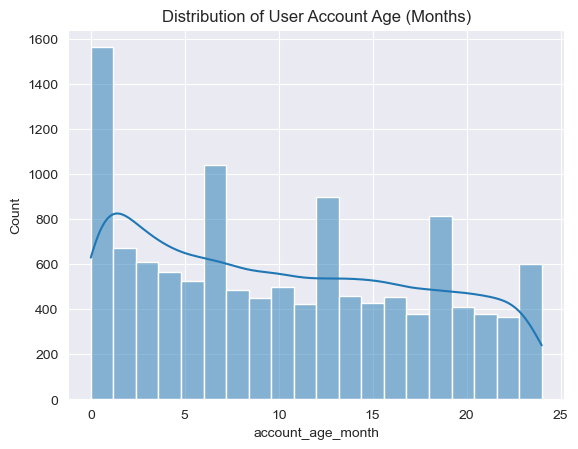

In [22]:
# Histogram for 'account_age_month'
sns.histplot(df_user['account_age_month'], bins=20, kde=True)
plt.title('Distribution of User Account Age (Months)')
plt.show()

#### Weekly Average Visit Count

Actionable Insight: There's a clear distinction between adopted and non-adopted users based on visit frequency. Might worth investigating why most of non-adopted users only visited the platform once a week.

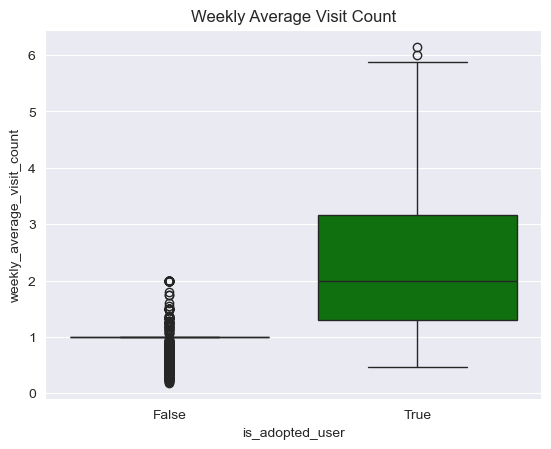

In [23]:
# Box plot for 'weekly_average_visit_count'
sns.boxplot(x='is_adopted_user', y='weekly_average_visit_count', data=df_user, palette={'True': 'green', 'False': 'red'})
plt.title('Weekly Average Visit Count')
plt.show()

#### Days Since Last User Visit

Actionable Insight: Non-adopted users exhibit less frequent engagement, as shown by the longer intervals since their last visit. Implementing re-engagement campaigns, such as targeted promotions or activity nudges for users showing signs of decreased activity, might reduce churn and improve adoption rates.

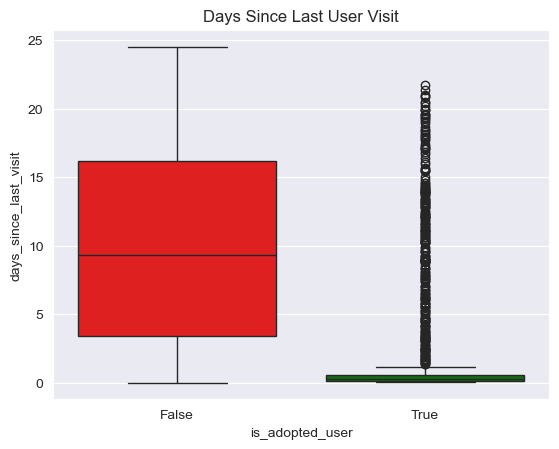

In [24]:
# Box plot for 'weekly_average_visit_count'
sns.boxplot(x='is_adopted_user', y='days_since_last_visit', data=df_user, palette={'True': 'green', 'False': 'red'})
plt.title('Days Since Last User Visit')
plt.show()

### 2. Quick Check if There's a Noticeable Trends Among Categorical vs Target Variable

The lack of clear trends in these visualizations suggests that creation source and the marketing strategies represented here may not be the primary drivers of user adoption.

It may be worthwhile to explore other user behaviors or characteristics that could influence adoption, such as feature usage, user engagement with the platform immediately after signing up, and responsiveness to different types of engagement initiatives.

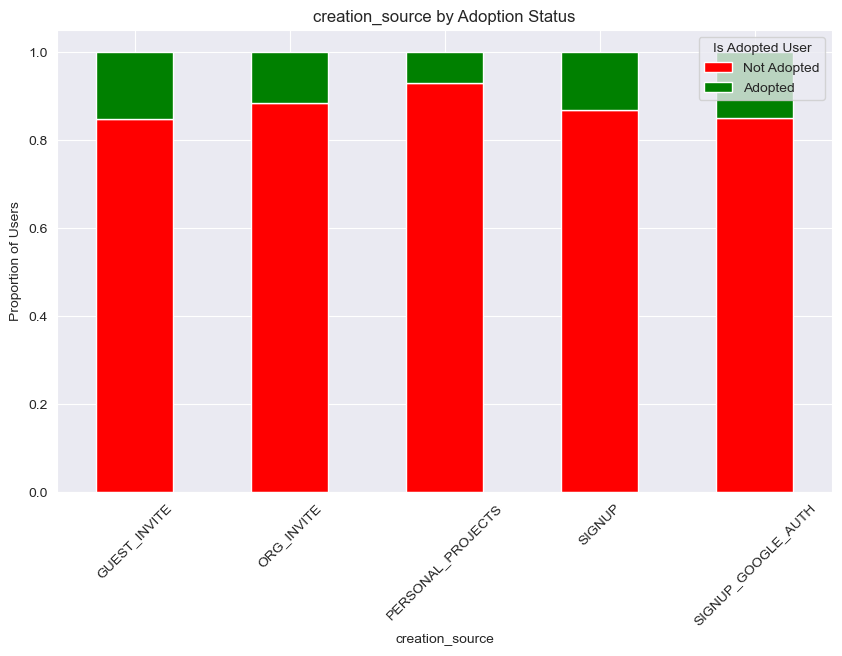

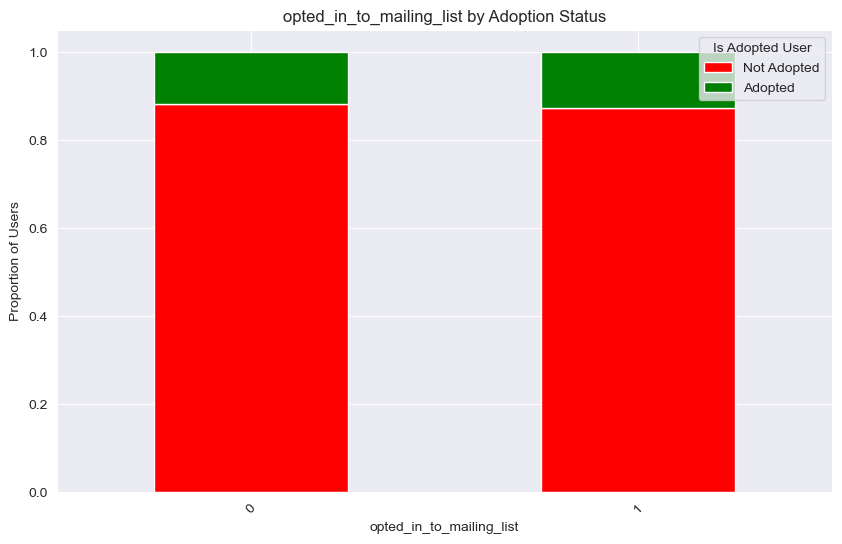

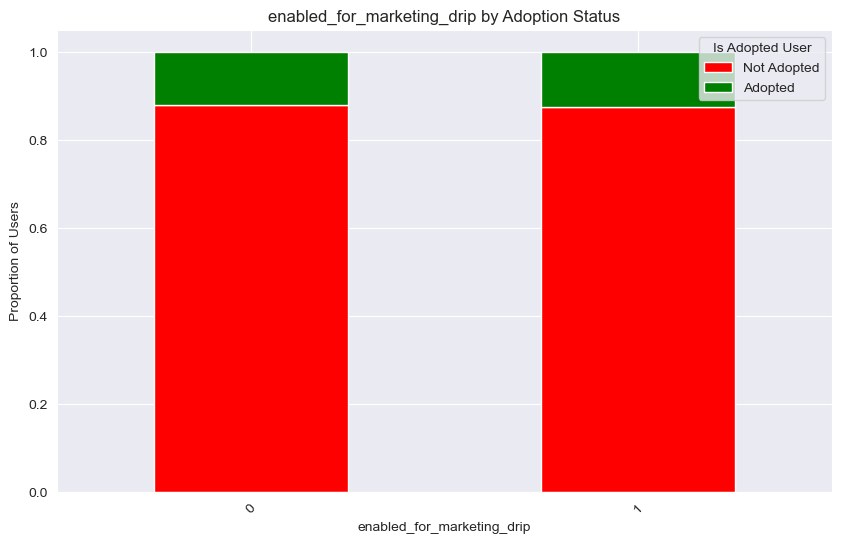

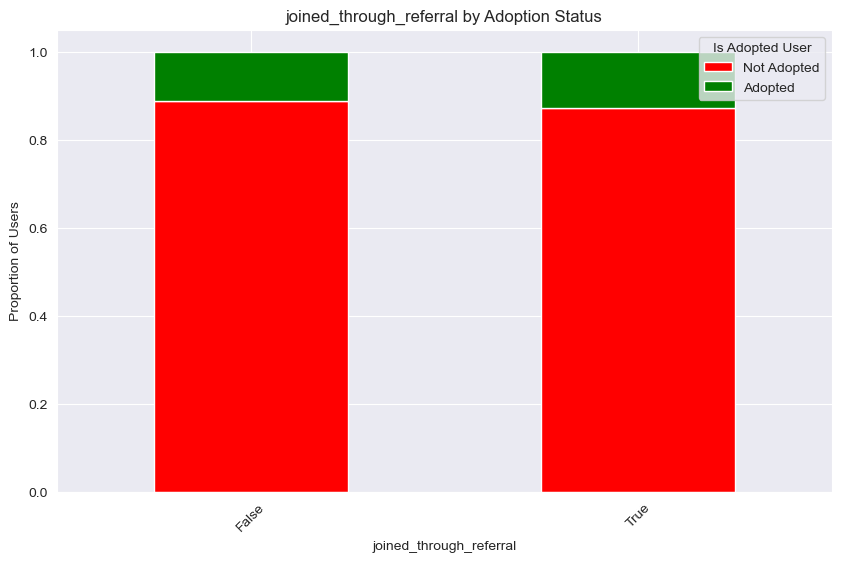

In [25]:
# Convert the 'is_adopted_user' column to string to use as a categorical variable
df_user['is_adopted_user_str'] = df_user['is_adopted_user'].astype(str)

categorical_columns = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'joined_through_referral']

for col in categorical_columns:
    # Create a crosstabulation of counts
    crosstab = pd.crosstab(df_user[col], df_user['is_adopted_user_str'])
    
    # Normalize to get proportions
    crosstab_prop = crosstab.div(crosstab.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    crosstab_prop.plot(kind='bar', stacked=True, color={'True': 'green', 'False': 'red'}, figsize=(10, 6))
    plt.title(f'{col} by Adoption Status')
    plt.xlabel(col)
    plt.ylabel('Proportion of Users')
    plt.legend(title='Is Adopted User', loc='upper right', labels=['Not Adopted', 'Adopted'])
    plt.xticks(rotation=45)
    plt.show()


## Correlation Analysis

### 1. Spearman Correlation

There is a quite significant positive correlation (0.65) between the weekly average visit count and adopted users suggests that higher platform engagement is a key indicator of user adoption. Consider developing strategies aimed at increasing user engagement, such as gamification or regular feature updates, to promote consistent usage.

A notable negative correlation with 'days_since_last_visit' aligns with the expectation that adopted users will have fewer days elapse between sessions. Consider re-engagement tactics targeting users who begin to show increased intervals between visits to prevent churn.

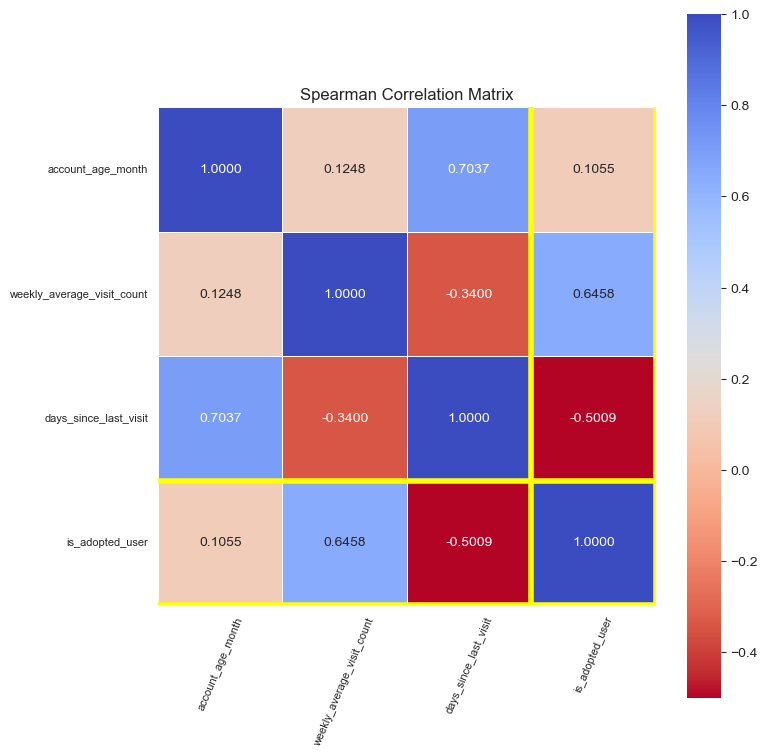

In [26]:
# Ensure 'is_adopted_user' is converted to a numeric type before computing correlation.
df_user['is_adopted_user'] = df_user['is_adopted_user'].astype(int)

# Listing the included columns
columns = ['account_age_month', 'weekly_average_visit_count', 'days_since_last_visit', 'is_adopted_user']

# Compute the correlation matrix including 'is_adopted_user'.
spearman_corr = df_user[columns].corr(method='spearman')

# Create a heatmap plot
_ = plt.figure(figsize=(8, 8))
# Create a custom color map
_ = sns.heatmap(
    spearman_corr, 
    annot=True, 
    fmt='.4f', # Ensure the annotation format is correct for floating-point numbers
    annot_kws={"size": 10},  # Adjust annotation font size if needed
    cmap='coolwarm_r',
    square=True,
    linewidths=.5
)

# Highlight the x and y-axis for a specific field name
field_name = 'is_adopted_user'
_ = plt.axhline(y=spearman_corr.index.get_loc(field_name), color='yellow', linewidth=4)
_ = plt.axhline(y=spearman_corr.index.get_loc(field_name)+1, color='yellow', linewidth=4)
_ = plt.axvline(x=spearman_corr.columns.get_loc(field_name), color='yellow', linewidth=4)
_ = plt.axvline(x=spearman_corr.columns.get_loc(field_name)+1, color='yellow', linewidth=4)

# Set the title and display the plot
_ = plt.title("Spearman Correlation Matrix", fontsize=12)
_ = plt.xticks(rotation=67, fontsize=8) # Rotate x labels
_ = plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

### 2. Chi-Square Test for Categorical Variables

In [27]:
categorical_columns = [
    'creation_source',
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'org_id',
    'has_visited_at_least_once',
    'joined_through_referral',
    'is_adopted_user'
]

# Define an empty DataFrame to store p-values
chi2_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
pvalues_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
cramerv_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Loop over each category
for row in categorical_columns:
    for col in categorical_columns:
        # Create contingency table
        contingency_table = pd.crosstab(
            index=df_user[row], #row
            columns=df_user[col] #col
        )
        # Perform Chi-square test
        chi2_statistic, pvalue, _, _ = stats.contingency.chi2_contingency(contingency_table)
        pvalues_matrix.loc[row, col] = pvalue
        chi2_matrix.loc[row, col] = chi2_statistic
        
        # Perform Cramer's V
        cramerv_value = stats.contingency.association(observed=contingency_table)
        cramerv_matrix.loc[row, col] = cramerv_value

# Convert the Matrix DataFrame values to float
chi2_matrix = chi2_matrix.astype(float)
pvalues_matrix = pvalues_matrix.astype(float)
cramerv_matrix = cramerv_matrix.astype(float)

### 3. Chi-Square P-Value Matrix

A review of the p-values indicates several statistically significant results. However, the impact of small sample sizes on these p-values cannot be ignored, as they may lead to overstated significance. Ensure sufficient sample size for robust statistical testing or complement the chi-square tests with qualitative analysis to better understand user behavior.

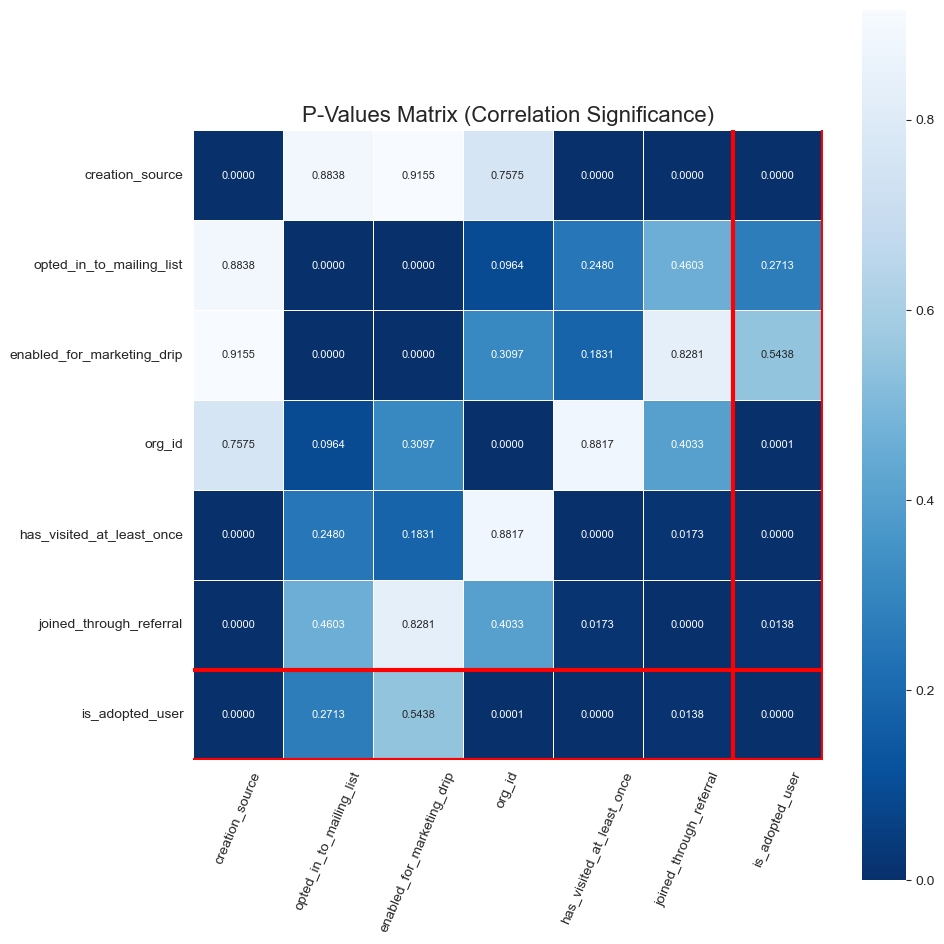

In [33]:
# Create a heatmap plot
_ = plt.figure(figsize=(10, 10))
# Create a custom color map
_ = sns.heatmap(
    pvalues_matrix, 
    annot=True, 
    fmt='.4f', # Ensure the annotation format is correct for floating-point numbers
    annot_kws={"size": 8},  # Adjust annotation font size if needed
    cmap='Blues_r',
    square=True,
    linewidths=.5
)

# Highlight the x and y-axis for a specific field name
field_name = 'is_adopted_user'
_ = plt.axhline(y=pvalues_matrix.index.get_loc(field_name), color='red', linewidth=3)
_ = plt.axhline(y=pvalues_matrix.index.get_loc(field_name)+1, color='red', linewidth=3)
_ = plt.axvline(x=pvalues_matrix.columns.get_loc(field_name), color='red', linewidth=3)
_ = plt.axvline(x=pvalues_matrix.columns.get_loc(field_name)+1, color='red', linewidth=3)

# Set the title and display the plot
_ = plt.title("P-Values Matrix (Correlation Significance)", fontsize=16)
_ = plt.xticks(rotation=67, fontsize=10) # Rotate x labels
_ = plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

### 4. Cramer's V Heatmap (To Check Association Strength)

The Cramer's V values for 'opted_in_to_mailing_list' and 'enabled_for_marketing_drip' suggest that these marketing strategies may not have a strong influence on whether users become adopted. Actionable Insight: Reevaluate the content and delivery of these communications to make them more effective or pivot to more impactful engagement channels.

Moderate associations seen with 'has_visited_at_least_once', 'org_id', and 'creation_source' highlight areas that might influence adoption:

- Has Visited At Least Once: While tautological, the association emphasizes the importance of first impressions and early engagement. It might worth considering the efforts on the onboarding process to ensure a user's initial experience is positive and engaging.

- Org ID: A moderate association suggests organizational culture or structure may affect adoption. Actionable Insight: Investigate the characteristics of organizations with high adoption rates to identify best practices that can be applied more broadly.

- Creation Source: The method by which users sign up appears to have some influence on adoption. Actionable Insight: Perform an in-depth analysis of each creation source to tailor and improve user acquisition strategies, potentially focusing on the most effective channels.

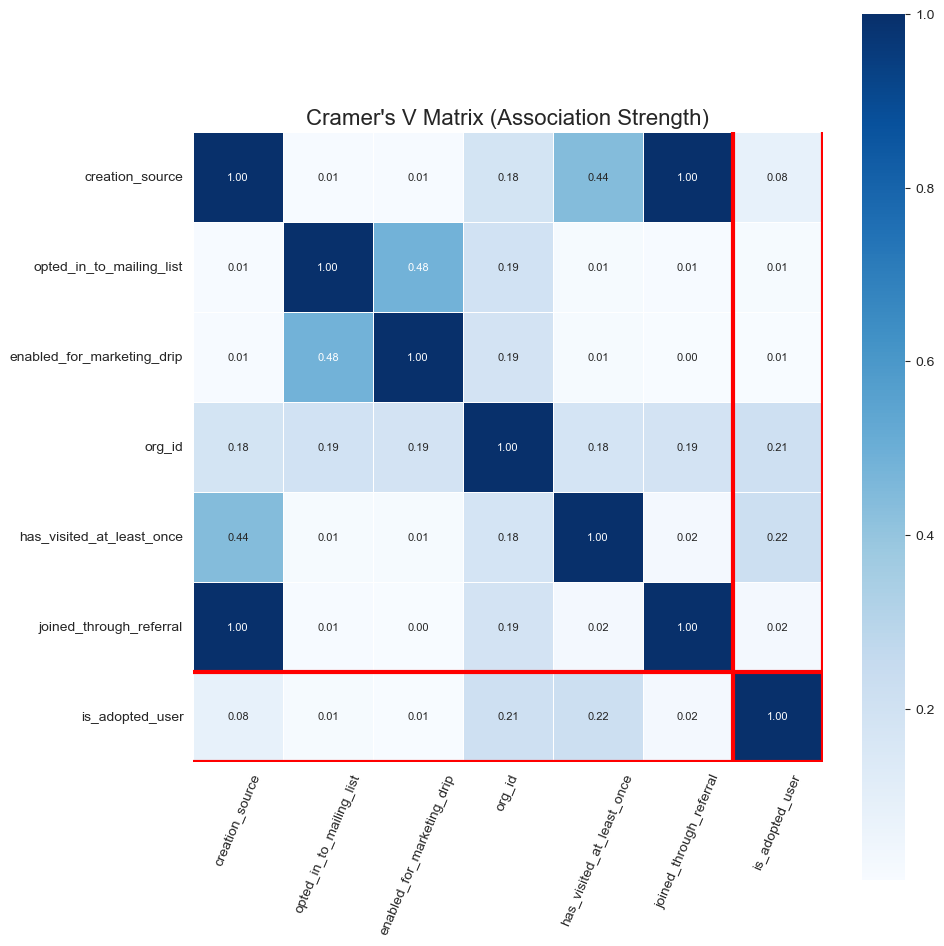

In [34]:
# Create a heatmap plot
_ = plt.figure(figsize=(10, 10))
# Create a custom color map
_ = sns.heatmap(
    cramerv_matrix, 
    annot=True, 
    fmt='.2f', # Ensure the annotation format is correct for floating-point numbers
    annot_kws={"size": 8},  # Adjust annotation font size if needed
    cmap='Blues',
    square=True,
    linewidths=.5
)

# Highlight the x and y-axis for a specific field name
field_name = 'is_adopted_user'
_ = plt.axhline(y=cramerv_matrix.index.get_loc(field_name), color='red', linewidth=3)
_ = plt.axhline(y=cramerv_matrix.index.get_loc(field_name)+1, color='red', linewidth=3)
_ = plt.axvline(x=cramerv_matrix.columns.get_loc(field_name), color='red', linewidth=3)
_ = plt.axvline(x=cramerv_matrix.columns.get_loc(field_name)+1, color='red', linewidth=3)

# Set the title and display the plot
_ = plt.title("Cramer's V Matrix (Association Strength)", fontsize=16)
_ = plt.xticks(rotation=67, fontsize=10) # Rotate x labels
_ = plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

## Conclusion

#### 1. User Account Activity Trends

- Seasonal Patterns in Signups: Semi-annual peaks in user signups suggest the influence of external factors or internal campaigns. Actionable Insight: Investigate the causes behind these peaks to understand what drives user signups and leverage these insights in planning future marketing efforts.
- Increasing Account Creation Rate: The recent uptick in account creation points to a growing interest in the product. Actionable Insight: Capitalize on this momentum with targeted engagement strategies for new users to bolster early adoption.

&nbsp;
#### 2. Engagement Metrics Correlation with Adoption

- Weekly Engagement: A strong correlation between weekly visit count and user adoption status underscores the importance of regular engagement. Actionable Insight: Incentivize frequent logins with engaging content, features, or rewards that encourage habitual use.
- Recency of Engagement: Negative correlation with days since last visit reaffirms the importance of consistent engagement. Actionable Insight: Implement monitoring systems to identify and re-engage users who are at risk of becoming inactive, using personalized outreach or special offers.

&nbsp;
#### 3. Categorical Variables and User Adoption

- Mailing List and Marketing Drip: The lack of a strong correlation between these marketing strategies and adoption indicates a need for reassessment. Actionable Insight: Revamp marketing communications to better engage users, perhaps by using more personalized and behavior-driven content.
- Organizational Influence: The moderate association between organization IDs and user adoption suggests that certain organizational environments are more conducive to adoption. Actionable Insight: Collaborate with organizations that have high adoption rates to identify best practices and potentially develop tailored features or services for these environments.
- Creation Source: Different creation sources seem to impact adoption rates, although not dominantly. Actionable Insight: Analyze the user experience for each creation source to optimize the onboarding process and identify the most effective channels for user acquisition.

&nbsp;
#### 4. Other Considerations and Further Research

- While creation source and marketing efforts do not show a strong direct impact on user adoption, they contribute to a broader ecosystem of user engagement. Actionable Insight: Further explore other behavioral factors, such as feature usage and responsiveness to onboarding processes, to gain a more holistic understanding of the drivers of adoption.
- User Behavior Post-Signup: The initial interactions of users with the platform can set the tone for ongoing engagement. Actionable Insight: Focus on delivering a compelling user experience right from the start and consider strategies that convert initial interest into sustained engagement.

-- End of Report --